In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
import keras_tuner as kt
import matplotlib.pyplot as plt
import seaborn as sns

### 1. data preprorcessing: prepare data for training & test sets

#### import dataset and data cleaning and selection 

The training dataset includes wind speeds of various altitude increments, in 10 minutes intervals, for a little more than 12 month. It includes horizontal wind speed, vertical wind speed, mean values, max and min values in the increments, standard deviations and other columns. 

There are certain unrealistic values for wind speeds suh as 9999 or 9998 or N/A, this is likely due to processing error in the technical instrumet.

Thus, for data cleaning, we will filter out the values above 50 as it is nearly impossible for wind speed in the given altitudes to exceed 50. And for data selection, we shall only use the columns that record the horizontal wind speeds as the HAWTs (Horizontal-Axis Wind Turbines) use the lift force of the horizontal winds to generate energy, and disregard the other data for now.  

In [2]:
file_path = "../Data/E05_Hudson_South_West_10_min_avg_20220129_20230128.xls"

data = pd.read_excel(file_path)

data.head()

,timestamp,lidar_lidar18m_Z10_HorizWS,lidar_lidar18m_Z10_StdDevWS,lidar_lidar18m_Z10_MaxWS,lidar_lidar18m_Z10_MinWs,lidar_lidar18m_WD_alg_03,lidar_lidar18m_Z10_VertWs,lidar_lidar18m_Z10_InfoFlag,lidar_lidar18m_Z10_StatFlag,lidar_lidar18m_Z10_Packets,...,AHRS_AHRSroll_Max,AHRS_AHRSroll_Min,AHRS_AHRSpitch_Max,AHRS_AHRSpitch_Min,AHRS_AHRSyaw_Max,AHRS_AHRSyaw_Min,buoy_status_CR6S_batt_Avg,buoy_status_GPSlat,buoy_status_GPSlong,FLS200_S/N
0,2022-01-29 00:00:00,10.4512,0.9643,13.4083,8.677,43.9618,0.2045,4,0,32,...,5.316,-7.165,5.282,-7.98,6.971,-6.687,12.97,39.4847,-73.5908,E05
1,2022-01-29 00:10:00,11.0738,0.8861,13.0669,9.1183,43.9564,0.3611,4,0,32,...,5.145,-6.437,5.686,-8.02,8.3,-7.213,12.97,39.4847,-73.5908,E05
2,2022-01-29 00:20:00,11.1295,1.0978,13.8472,8.8772,44.2444,0.2759,4,0,32,...,6.586,-8.72,6.736,-9.23,8.15,-8.99,12.97,39.4847,-73.5909,E05
3,2022-01-29 00:30:00,11.0591,1.0196,13.7819,9.2176,46.5821,0.1763,4,0,33,...,6.492,-7.805,8.22,-8.76,6.353,-8.91,12.97,39.4847,-73.5909,E05
4,2022-01-29 00:40:00,11.1425,0.8374,13.1432,9.2309,49.2058,0.3055,6,0,33,...,6.116,-7.546,6.578,-8.84,8.57,-10.83,12.97,39.4847,-73.5909,E05


In [3]:
# Filtering columns with 'HorizWS' in their names
horiz_ws_columns = [col for col in data.columns if 'lidar_lidar138m_Z10_HorizWS' in col]
horiz_ws_data = data[horiz_ws_columns]

# Converting wind speed columns to numeric, setting errors='coerce' to turn non-numeric values into NaN
numeric_horiz_ws_data = horiz_ws_data.apply(pd.to_numeric, errors='coerce')

# Filtering out all values above 50
cleaned_numeric_horiz_ws_data = numeric_horiz_ws_data[numeric_horiz_ws_data <= 50].dropna()

# Displaying the first few rows of the cleaned numeric data
cleaned_numeric_horiz_ws_data.head()

,lidar_lidar138m_Z10_HorizWS
0,11.5242
1,11.9534
2,11.9038
3,12.4251
4,12.3536


#### Data normalization

The data is normalized with MinMax (imported from the scikit-learn library) for MinMax scaling's ability to transform data into a bounded range while preserving temporal relationships. It is suitable for TimeGAN models like this one, which are designed to generate realistic time-series data.

In [4]:
# Initializing the MinMaxScaler to scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fitting the scaler to the cleaned data and transforming it
normalized_data = scaler.fit_transform(cleaned_numeric_horiz_ws_data)

# Converting the normalized data back to a DataFrame for better readability
normalized_df = pd.DataFrame(normalized_data, columns=cleaned_numeric_horiz_ws_data.columns)

# Displaying the first few rows of the normalized data
normalized_df.head()

,lidar_lidar138m_Z10_HorizWS
0,0.325370
1,0.337943
2,0.336490
3,0.351761
4,0.349666


#### Reshaping the data

LSTM model is chosen to focus on seasonal variations so the previos

In [5]:
# Function to convert the dataset into a supervised learning problem
def create_dataset(X, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(X.iloc[i + time_steps])  # Target value to predict
    return np.array(Xs), np.array(ys)

# Choosing a time step for LSTM
time_steps = 10  # Represents how many time steps back the network will learn

# Structuring the data for LSTM
X, y = create_dataset(normalized_df, time_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8, random_state = 42)

# Displaying the shape of the structured data
X_train.shape, X_test.shape

((9708, 10, 1), (38836, 10, 1))

#### Defining model dimensions

In [6]:
n_neurons = 128
activation = "relu"
num_epochs = 100
learning_rate = 0.001
minibatch_size = 64

#### Defining the GAN model

In [7]:
def build_lstm_generator(seq_len, n_features, latent_dim=100):
    model = Sequential()
    model.add(Dense(n_neurons, activation='relu', input_dim=latent_dim))
    model.add(RepeatVector(seq_len))
    model.add(LSTM(n_neurons, return_sequences=True))
    model.add(TimeDistributed(Dense(n_features, activation='sigmoid')))
    return model

def build_lstm_discriminator(seq_len, n_features):
    model = Sequential()
    model.add(LSTM(n_neurons, input_shape=(seq_len, n_features), return_sequences=True))
    model.add(LSTM(n_neurons))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [8]:
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

In [9]:
# Assuming seq_len and n_features are defined based on your data
seq_len = time_steps  # Example: 10 time steps
n_features = 1  # Example: 1 feature per time step
latent_dim = 100  # Size of the noise vector

# Build the models
generator = build_lstm_generator(seq_len, n_features, latent_dim)
discriminator = build_lstm_discriminator(seq_len, n_features)
gan = build_gan(generator, discriminator)

# Training loop
epochs = 2000
batch_size = 64

for epoch in range(epochs):
    # ----- Train Discriminator -----
    # Select a random batch of real data
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_seqs = X_train[idx]

    # Generate a batch of synthetic data    
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    synthetic_seqs = generator.predict(noise)
    
    # Generate a batch of synthetic data
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    synthetic_seqs = generator.predict(noise)

    # Labels for real and synthetic data
    real_y = np.ones((batch_size, 1))
    synthetic_y = np.zeros((batch_size, 1))

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(real_seqs, real_y)
    d_loss_synthetic = discriminator.train_on_batch(synthetic_seqs, synthetic_y)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_synthetic)

    # ----- Train Generator -----
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    valid_y = np.ones((batch_size, 1))  # Labels for generator training

    # Train the generator (to have the discriminator label samples as valid)
    g_loss = gan.train_on_batch(noise, valid_y)

    # Print progress every few epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{epochs} - D Loss: {d_loss}, G Loss: {g_loss}")

2/2 [==============================] - 0s 0s/step
Epoch 0/2000 - D Loss: [0.71988156 0.5       ], G Loss: 0.6577427387237549
2/2 [==============================] - 0s 0s/step
Epoch 100/2000 - D Loss: [0.26597005 0.890625  ], G Loss: 1.970674991607666
2/2 [==============================] - 0s 0s/step
Epoch 200/2000 - D Loss: [0.29814711 0.8984375 ], G Loss: 1.8570940494537354
2/2 [==============================] - 0s 0s/step
Epoch 300/2000 - D Loss: [0.66580412 0.5390625 ], G Loss: 0.904740571975708
2/2 [==============================] - 0s 0s/step
Epoch 400/2000 - D Loss: [0.68897241 0.5546875 ], G Loss: 0.7093701958656311
2/2 [==============================] - 0s 4ms/step
Epoch 500/2000 - D Loss: [0.69468522 0.4609375 ], G Loss: 0.7213215231895447
2/2 [==============================] - 0s 3ms/step
Epoch 600/2000 - D Loss: [0.68636948 0.5234375 ], G Loss: 0.7873790264129639
2/2 [==============================] - 0s 0s/step
Epoch 700/2000 - D Loss: [0.68140271 0.5       ], G Loss: 0.767

In [13]:
# Saving the models
generator.save('./saved_model/generator_model.h5')
discriminator.save('./saved_model/discriminator_model.h5')

In [14]:
loaded_generator = load_model('./saved_model/generator_model.h5')
loaded_discriminator = load_model('./saved_model/discriminator_model.h5')

In [15]:
# Generate synthetic data
#noise = np.random.normal(0, 1, (number_of_samples, latent_dim))
synthetic_data = loaded_generator.predict(noise)

# Optionally, visualize or perform statistical analysis on synthetic_data

2/2 [==============================] - 0s 16ms/step


C:\Users\Jiarong Xie\AppData\Local\Temp\ipykernel_61160\649582215.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(real_data_flat, label='Real Data', hist=False, color="green", kde=True, norm_hist=True)
C:\Users\Jiarong Xie\AppData\Local\Temp\ipykernel_61160\649582215.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de

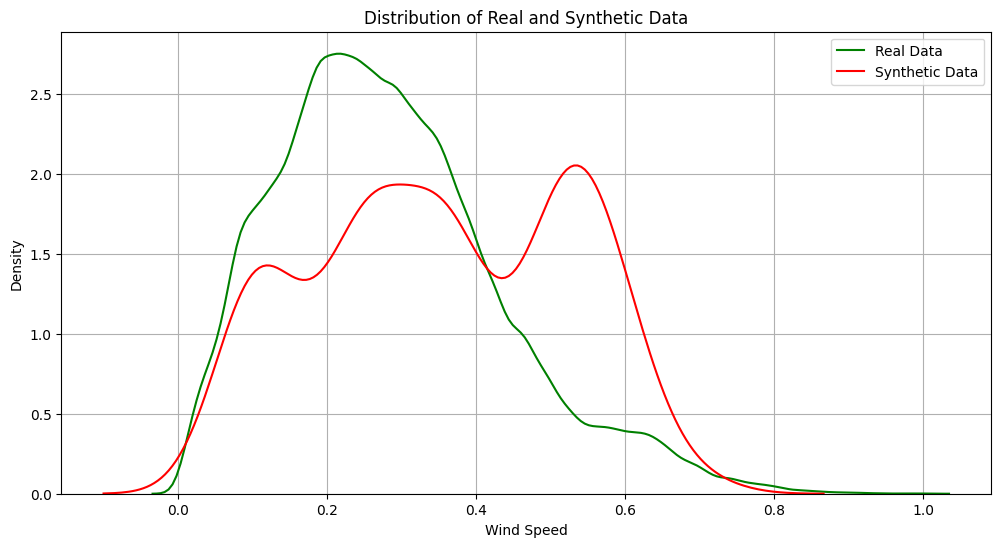

In [16]:
real_data_flat = X_test.flatten()
synthetic_data_flat = synthetic_data.flatten()

plt.figure(figsize=(12, 6))

# Distribution plot for real data
sns.distplot(real_data_flat, label='Real Data', hist=False, color="green", kde=True, norm_hist=True)

# Distribution plot for synthetic data
sns.distplot(synthetic_data_flat, label='Synthetic Data', hist=False, color="red", kde=True, norm_hist=True)

plt.title('Distribution of Real and Synthetic Data')
plt.xlabel('Wind Speed')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.show()

In [30]:
from netCDF4 import Dataset as netcdf 
import xarray as xr
import cftime
from geopy.geocoders import Nominatim

2000-01-16 00:00:00
2008-05-16 00:00:00
(180, 20, 15)
London, Greater London, England, United Kingdom
-0.1277653 51.5074456


Text(0.5, 1.0, 'Compare CMIP Wind Speed prediction for London')

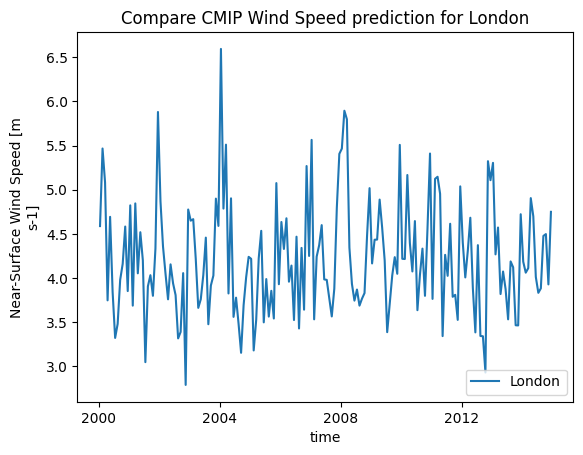

In [31]:
ds1 = xr.open_dataset('../Data/UK_Historical_Wind.nc')
ncset1 = netcdf('../Data/UK_Historical_Wind.nc', mode='r')
ncset1.set_auto_mask(False)
lon1 = ncset1['lon'][:]
lat1 = ncset1['lat'][:]
t1 = ncset1['time'][:]
sfcWind = ncset1['sfcWind'][:]
nctime1 = ncset1.variables['time'][:]
t_unit1 = ncset1.variables['time'].units
ncset1.close()

try:
    t_cal1 = nctime1.calendar
except AttributeError:  # Attribute doesn't exist
    t_cal1 = u"360_day"  # or standard
datevar1 = cftime.num2date(nctime1, units=t_unit1, calendar=t_cal1)

[lons, lats] = np.meshgrid(lon1, lat1)

print(datevar1[0])
print(datevar1[100])
print(sfcWind.shape)
geolocator = Nominatim(user_agent="Google Geocoding API (V3)")
location = geolocator.geocode("London")
print(location.address)
print(geolocator.geocode("London").longitude,geolocator.geocode("London").latitude)

# Get coords of cities
lons1,lats1=geolocator.geocode("London").longitude,geolocator.geocode("London").latitude

ds1.sfcWind.sel(lon=lons1, lat=lats1, method = 'nearest').plot.line(x="time")

# Get data for coords

labels = ['London']

plt.legend(labels,loc='lower right')
plt.title('Compare CMIP Wind Speed prediction for ' + labels[0])

In [32]:
# Extract data for London
london_data = ds1.sfcWind.sel(lon=lons1, lat=lats1, method='nearest').to_dataframe()

# Normalize the data
trimmed_london_data = london_data.iloc[:, -1].values
#trimmed_london_data_repeat = np.repeat(trimmed_london_data, 30)
trimmed_london_data_reshaped = trimmed_london_data.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
london_data_scaled = scaler.fit_transform(trimmed_london_data_reshaped)
#trimmed_london_data_scaled = london_data_scaled[:, -1:]

# Convert to supervised learning structure
def create_dataset(X, time_steps=1):
    Xs = []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
    return np.array(Xs)

time_steps = time_steps  # same as used in the model
london_data_supervised = create_dataset(pd.DataFrame(london_data_scaled), time_steps)

# Split the data
split_idx = int(0.0075 * len(london_data_supervised))
london_data_train = london_data_supervised[:split_idx]
london_data_test = london_data_supervised[split_idx:]

In [34]:
london_data_train.shape

(1, 10, 1)

In [35]:
# Assuming `generator` is your Keras model
input_shape = generator.layers[0].input_shape

# Print the expected input shape
print(f"The expected input shape for the generator model is: {input_shape}")

The expected input shape for the generator model is: (None, 100)


In [38]:
split_idx_trimmed = int(0.0075 * len(trimmed_london_data))
london_data_train_trimmed = trimmed_london_data[:split_idx]

data_point = np.array([london_data_train_trimmed])  # your data point
transformed_data_point = np.repeat(data_point, 100).reshape(1, -1)  # transform to (1, 100)

generated_data_points = []

# Generate 2880 data points
for _ in range(2880):
    generated_point = generator.predict(transformed_data_point)
    # Assuming the generated point is the shape you need, append it to the list
    generated_data_points.append(generated_point)

# Convert the list to a numpy array for easier manipulation if needed
generated_data_points = np.array(generated_data_points).reshape(2880, -1)

1/1 [==============================] - 0s 20ms/step


In [45]:
trimmed_london_data_repeat = np.repeat(london_data_train_trimmed, num_points_to_generate)
london_pred_inversed = scaler.inverse_transform(generated_data_points)

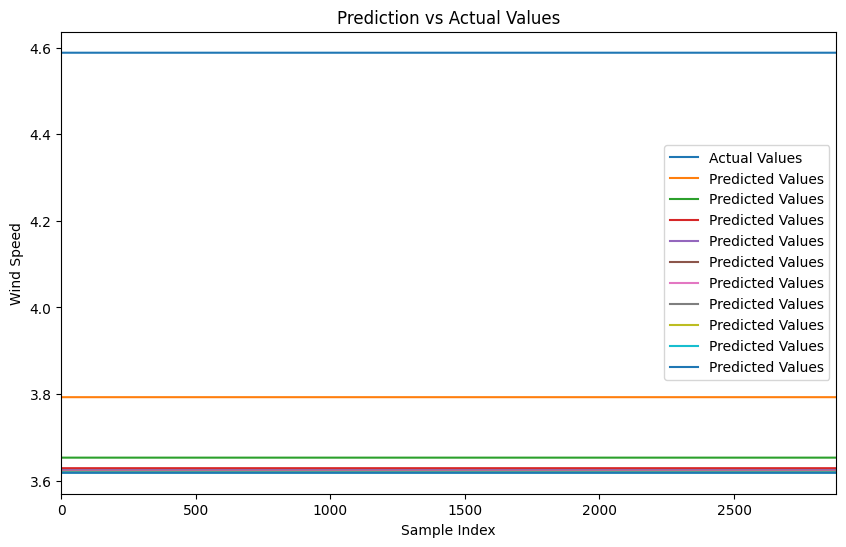

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(trimmed_london_data_repeat, label='Actual Values')
plt.plot(london_pred_inversed, label='Predicted Values')
plt.title('Prediction vs Actual Values')
plt.xlabel('Sample Index')
plt.ylabel('Wind Speed')
plt.xlim([0, london_pred_inversed.shape[0]])
plt.legend()
plt.show()

In [37]:
num_days = 30
points_per_day = 24 * 4  # Assuming you want to generate data for every 15 minutes in a day
num_points_to_generate = num_days * points_per_day

generated_data = []

# Assuming seed_sequence is a numpy array with shape (1, sequence_length, num_features)
current_sequence = np.copy(london_data_train)

for i in range(num_points_to_generate):
    # Predict the next point
    next_point = generator.predict(transformed_data_point)

    # Check the shape of next_point and append the prediction to generated_data
    # If next_point is 2D, it's likely shaped as (1, num_features)
    generated_data.append(next_point[0])

    # Update the sequence
    current_sequence = np.roll(current_sequence, -1, axis=1)
    # Assuming next_point[0] is the array of features you want to include
    current_sequence[0, -1, :] = next_point[0]

# Convert the list of generated points to a numpy array
generated_data = np.array(generated_data)

1/1 [==============================] - 0s 12ms/step


ValueError: could not broadcast input array from shape (10,1) into shape (1,)

In [ ]:
london_pred_inversed = scaler.inverse_transform(generated_data)


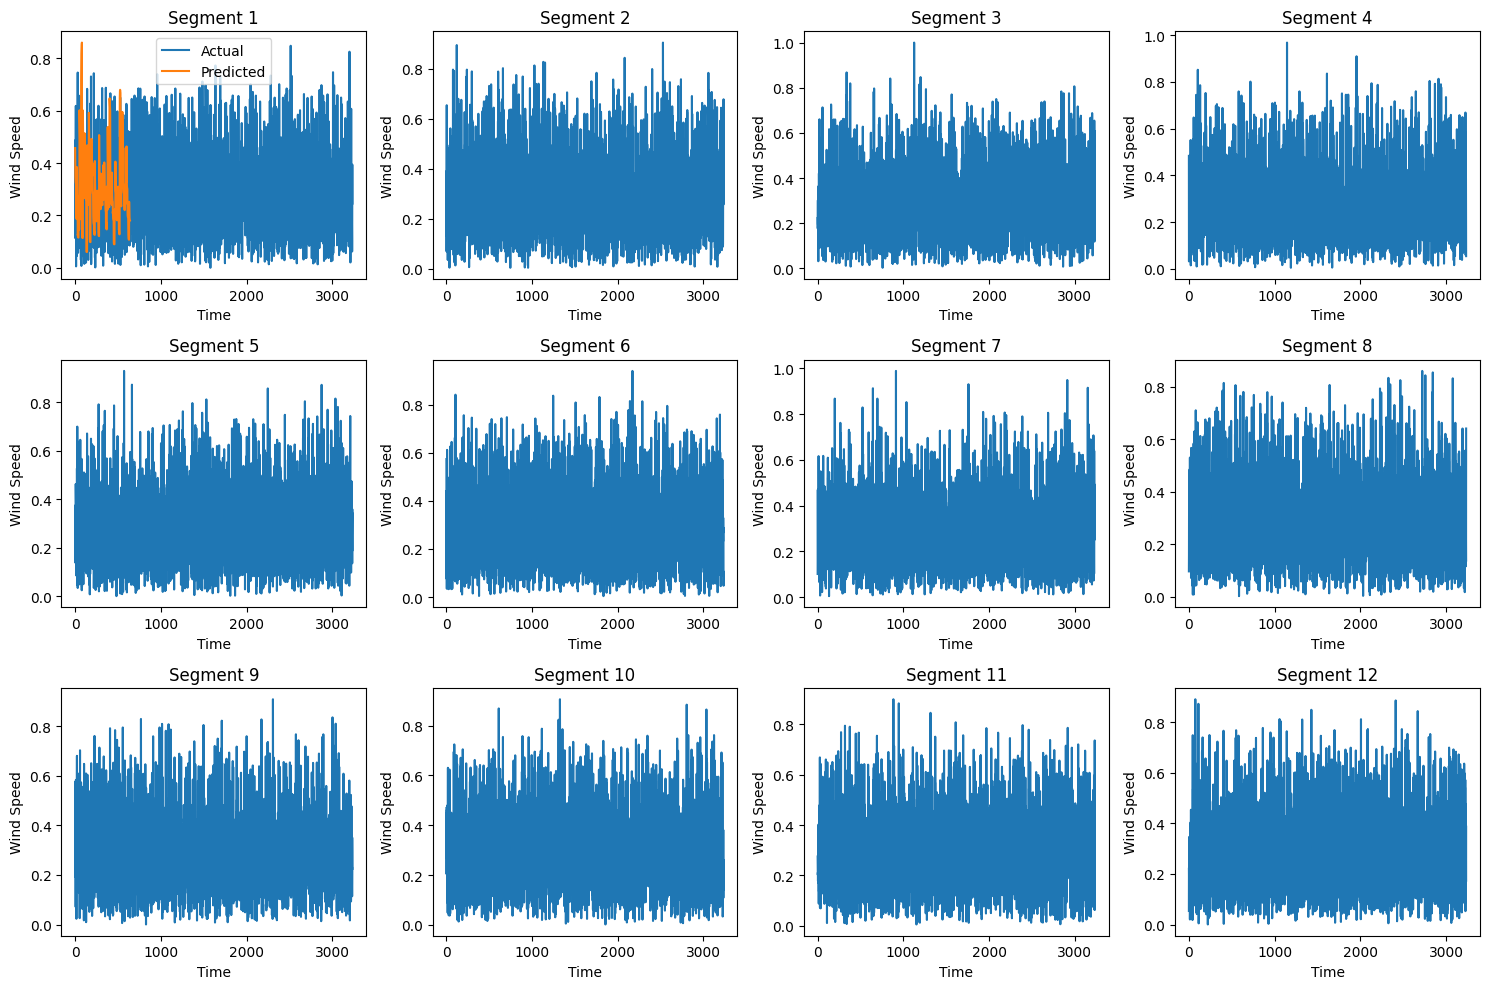

In [27]:
# Assuming y_test and y_pred are your actual and predicted values
num_plots = 12
total_points = len(y_test)
points_per_plot = total_points // num_plots

plt.figure(figsize=(15, 10))  # Adjust the size as needed

for i in range(num_plots):
    plt.subplot(3, 4, i + 1)
    start_idx = i * points_per_plot
    end_idx = start_idx + points_per_plot
    plt.plot(y_test[start_idx:end_idx], label='Actual')
    plt.plot(synthetic_data_flat[start_idx:end_idx], label='Predicted')
    plt.title(f'Segment {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Wind Speed')
    if i == 0:  # Only add legend to the first plot to avoid clutter
        plt.legend()

plt.tight_layout()
plt.show()

C:\Users\Jiarong Xie\AppData\Local\Temp\ipykernel_26636\881234559.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test_flat, label='Actual Values', hist=True, color="green", kde=True, norm_hist=True)
C:\Users\Jiarong Xie\AppData\Local\Temp\ipykernel_26636\881234559.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad637

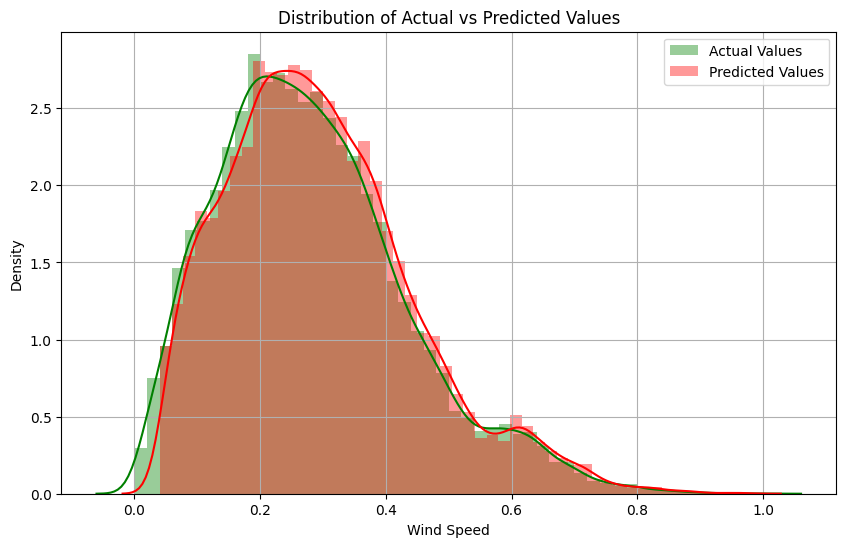

In [13]:
plt.figure(figsize=(10, 6))
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()
sns.distplot(y_test_flat, label='Actual Values', hist=True, color="green", kde=True, norm_hist=True)
sns.distplot(y_pred_flat, label='Predicted Values', hist=True, color="red", kde=True, norm_hist=True)
plt.title('Distribution of Actual vs Predicted Values')
plt.xlabel('Wind Speed')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.show()

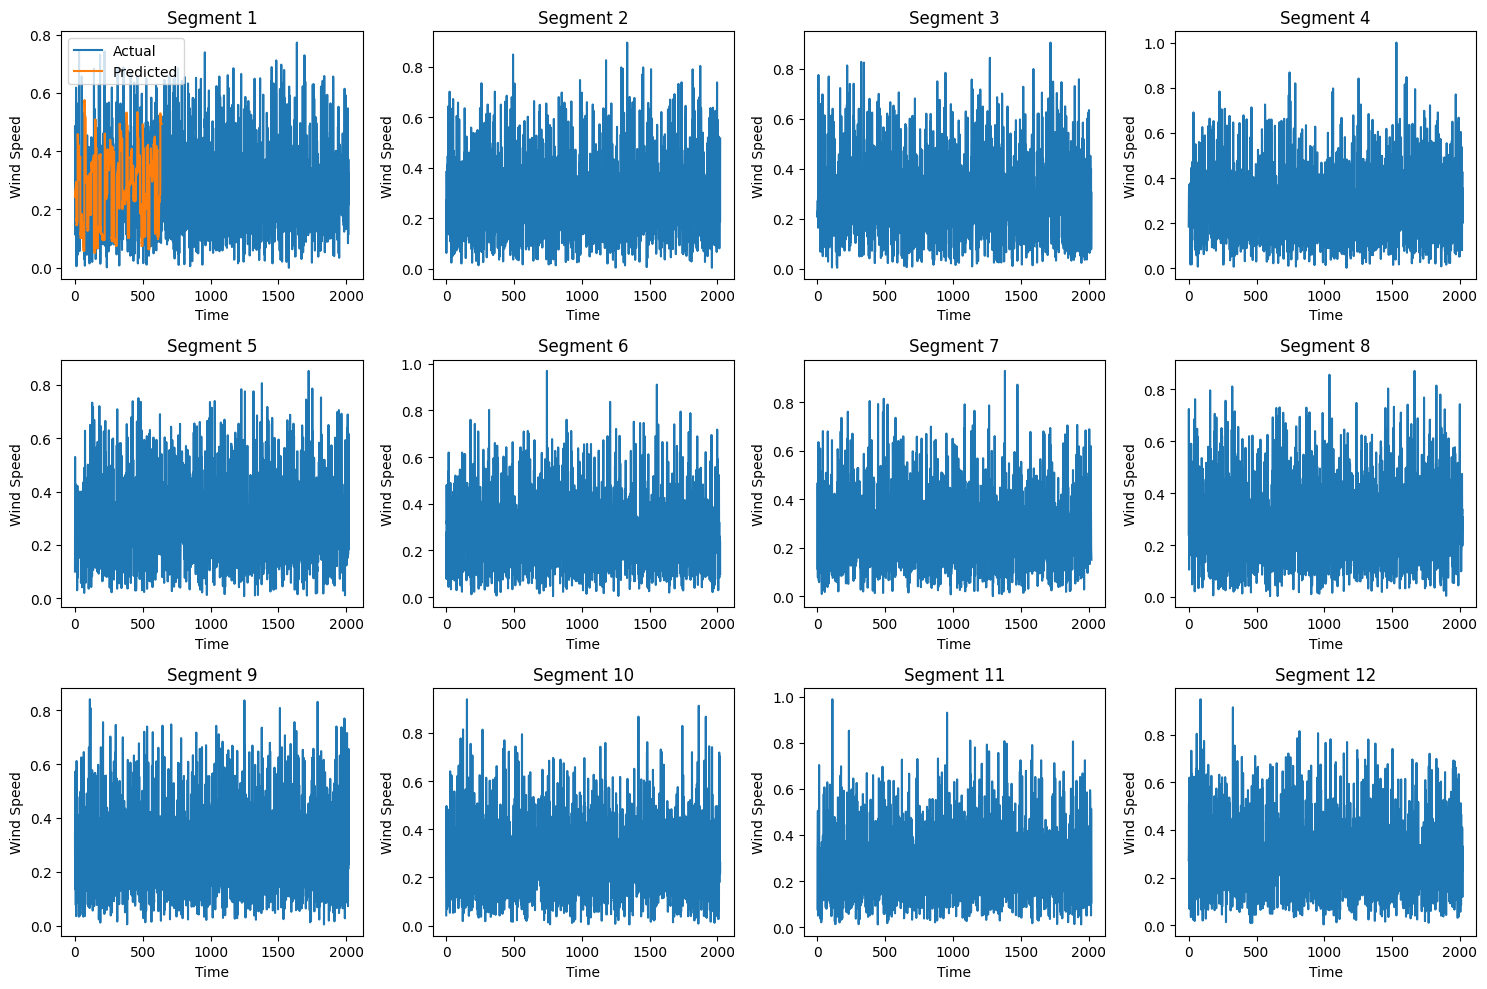

In [26]:
# Assuming y_test and y_pred are your actual and predicted values
num_plots = 12
total_points = len(y_test)
points_per_plot = total_points // num_plots

plt.figure(figsize=(15, 10))  # Adjust the size as needed

for i in range(num_plots):
    plt.subplot(3, 4, i + 1)
    start_idx = i * points_per_plot
    end_idx = start_idx + points_per_plot
    plt.plot(y_test[start_idx:end_idx], label='Actual')
    plt.plot(synthetic_data_flat[start_idx:end_idx], label='Predicted')
    plt.title(f'Segment {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Wind Speed')
    if i == 0:  # Only add legend to the first plot to avoid clutter
        plt.legend()

plt.tight_layout()
plt.show()

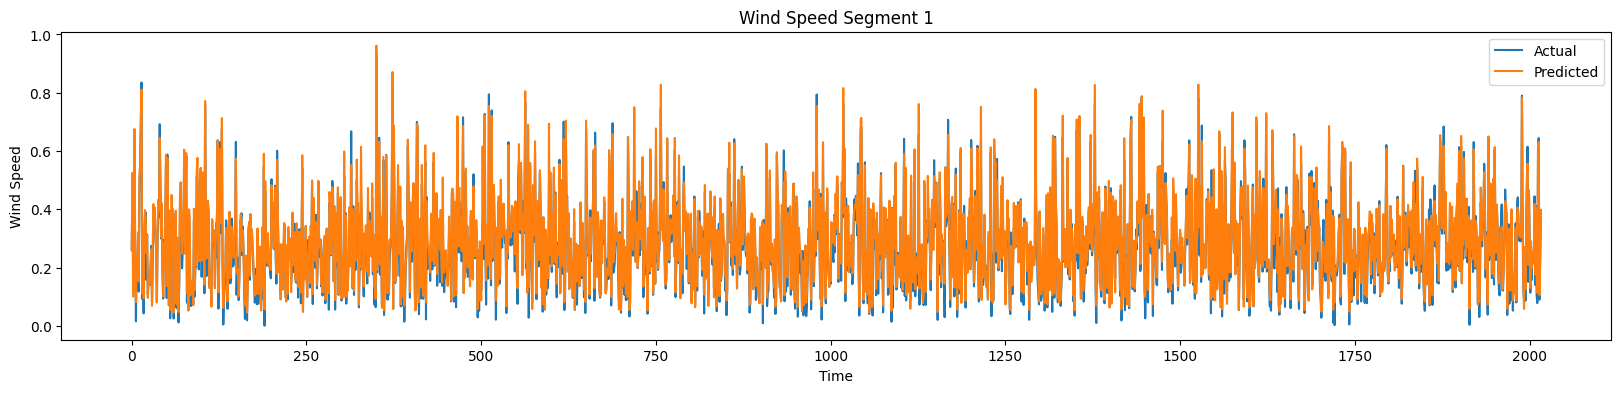

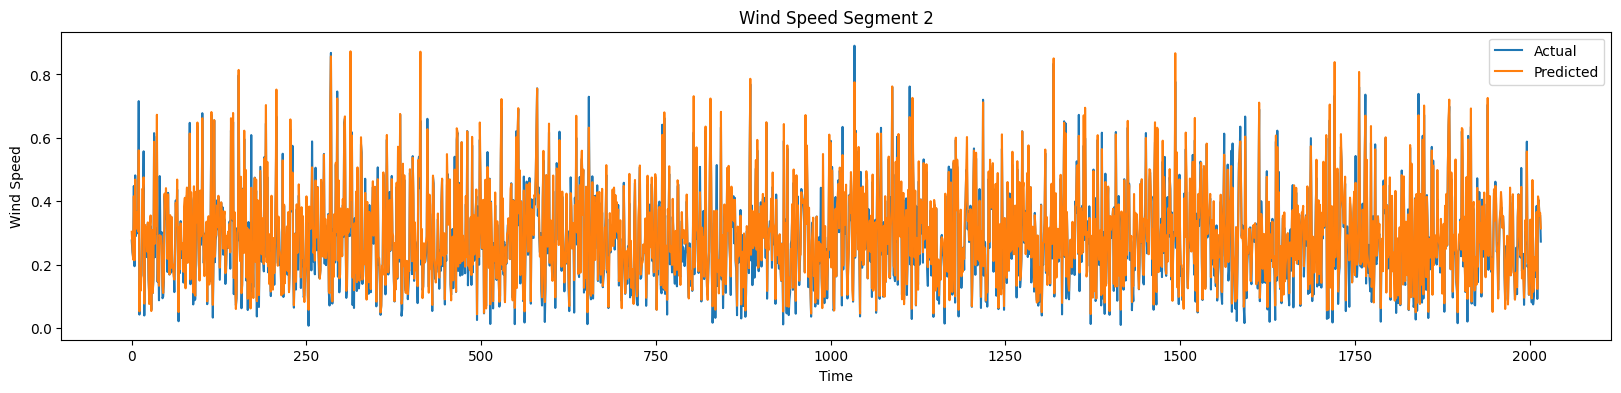

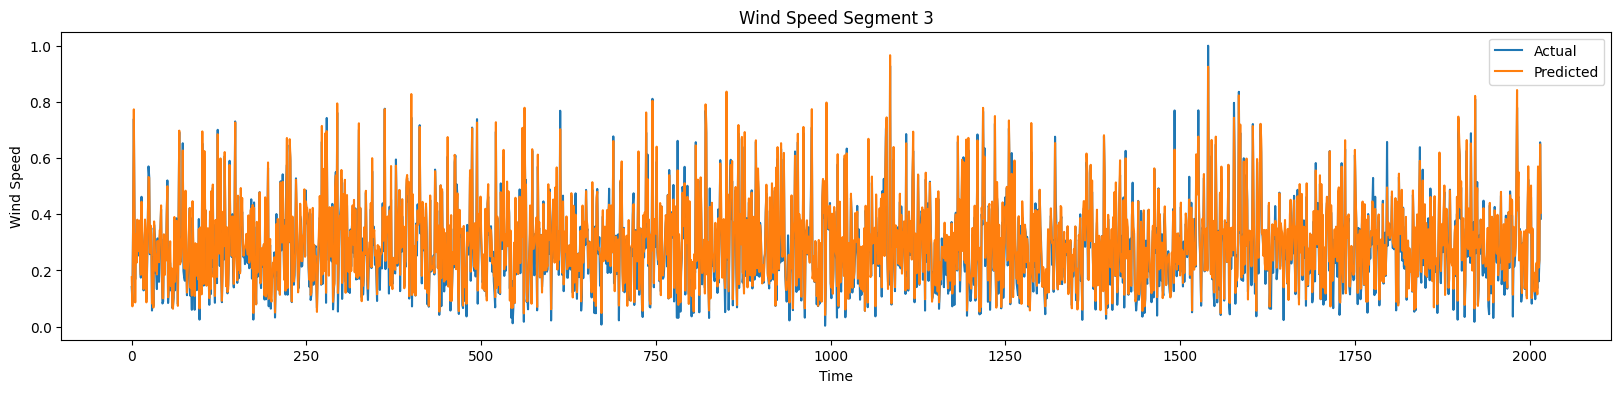

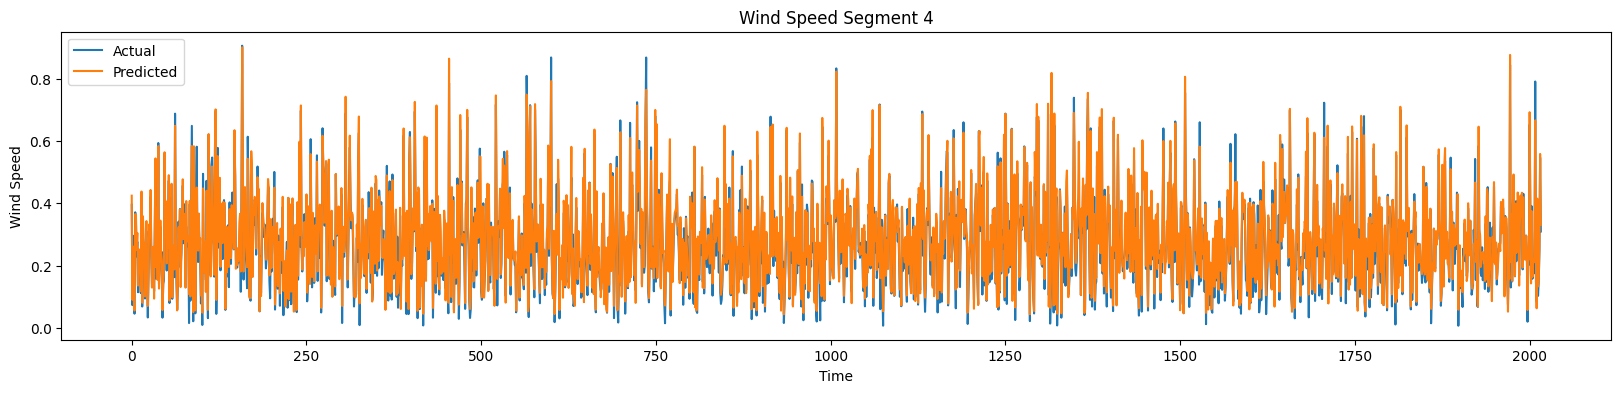

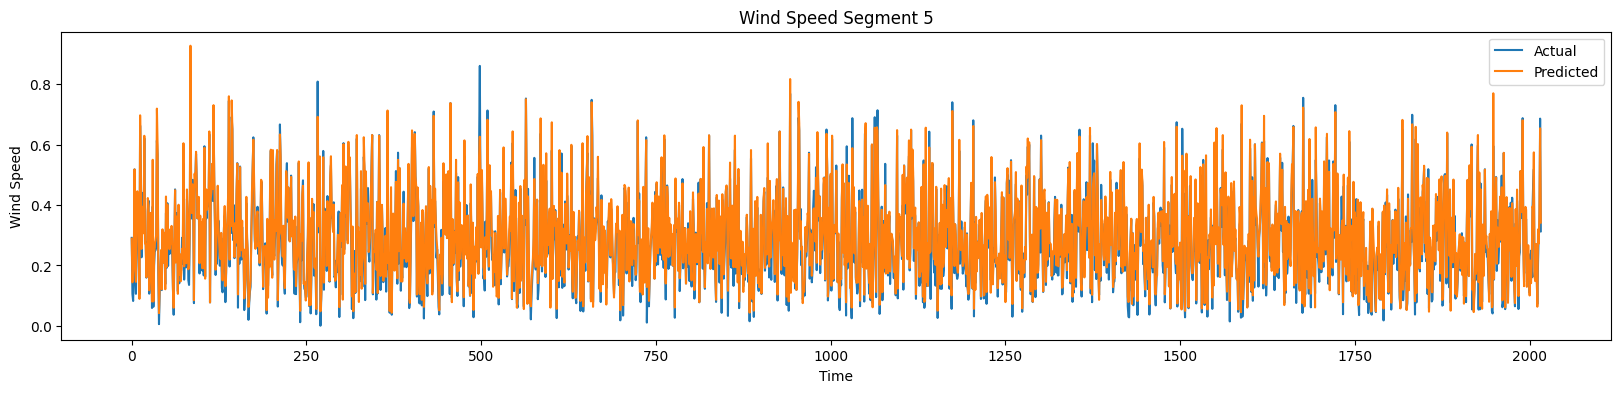

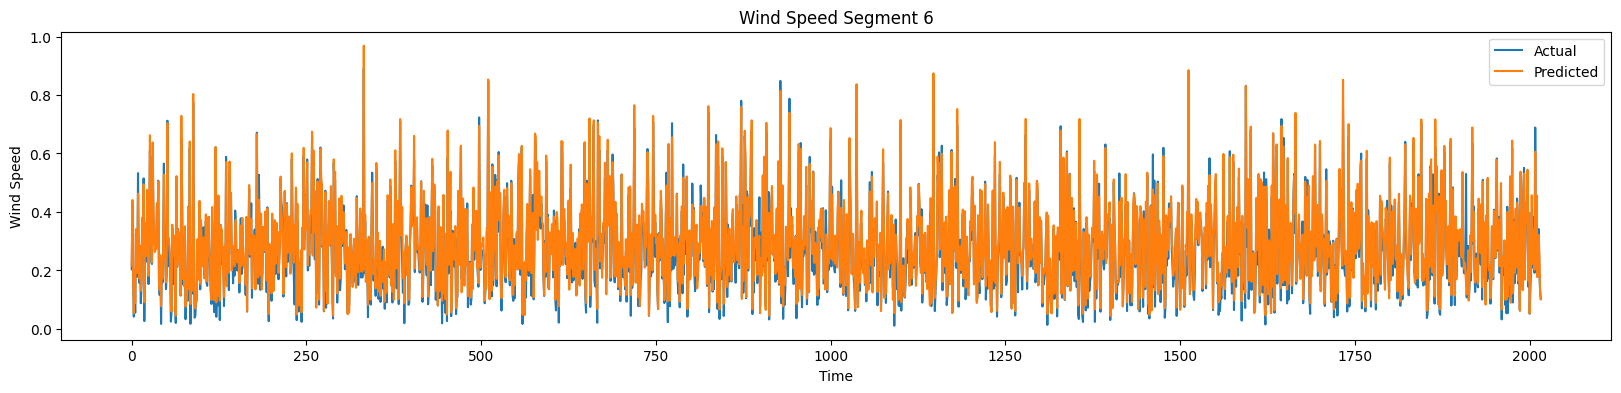

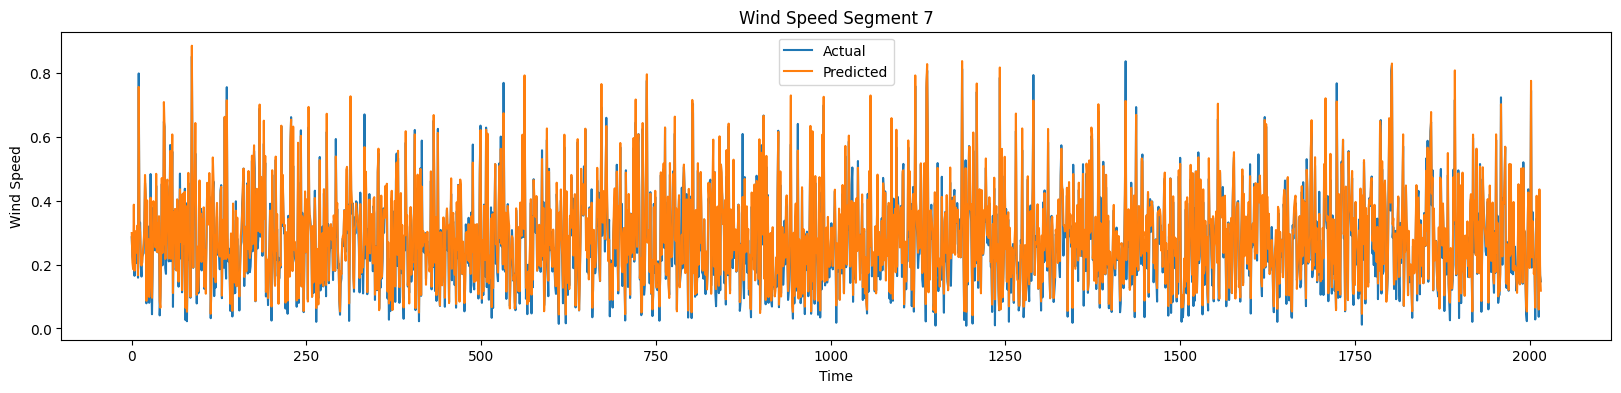

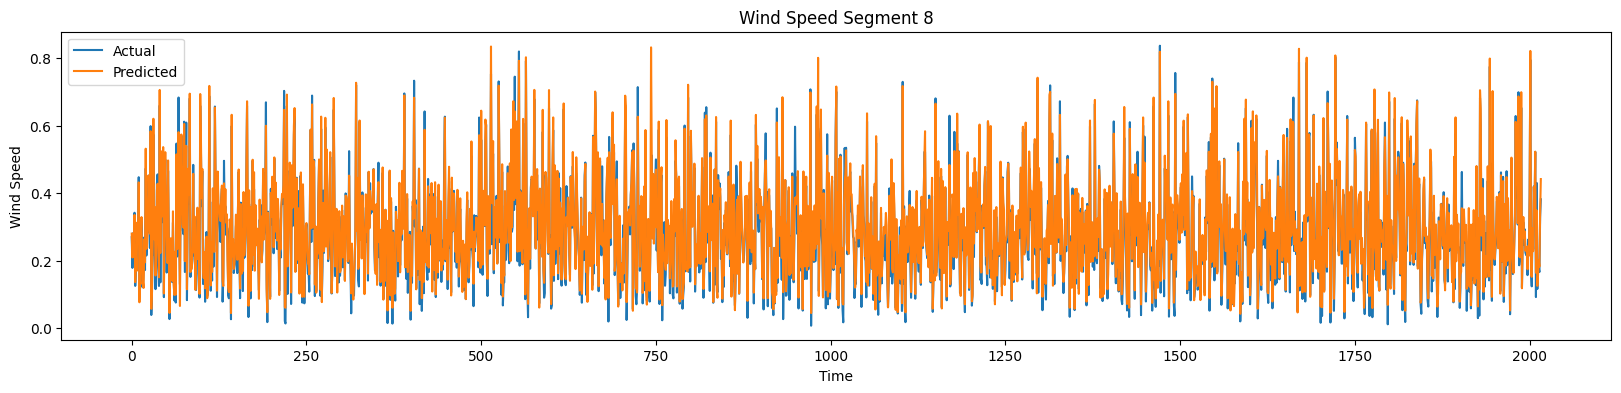

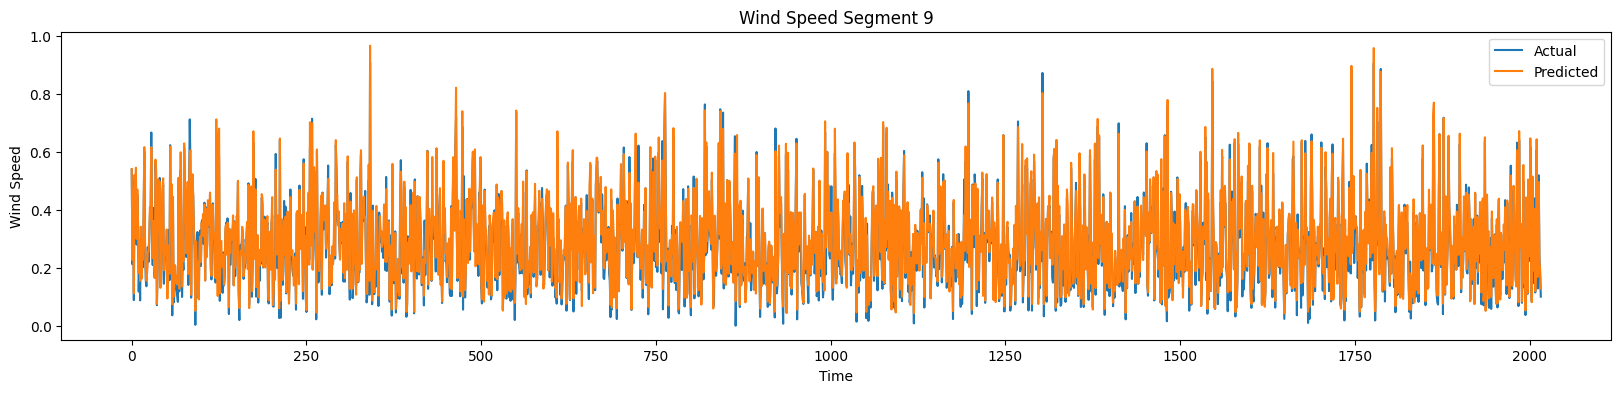

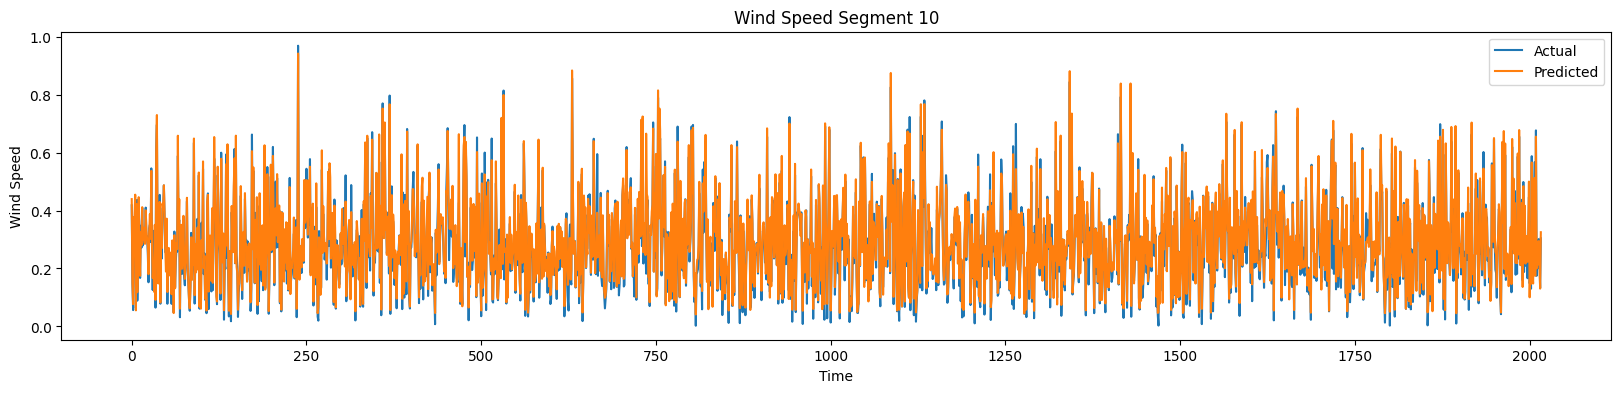

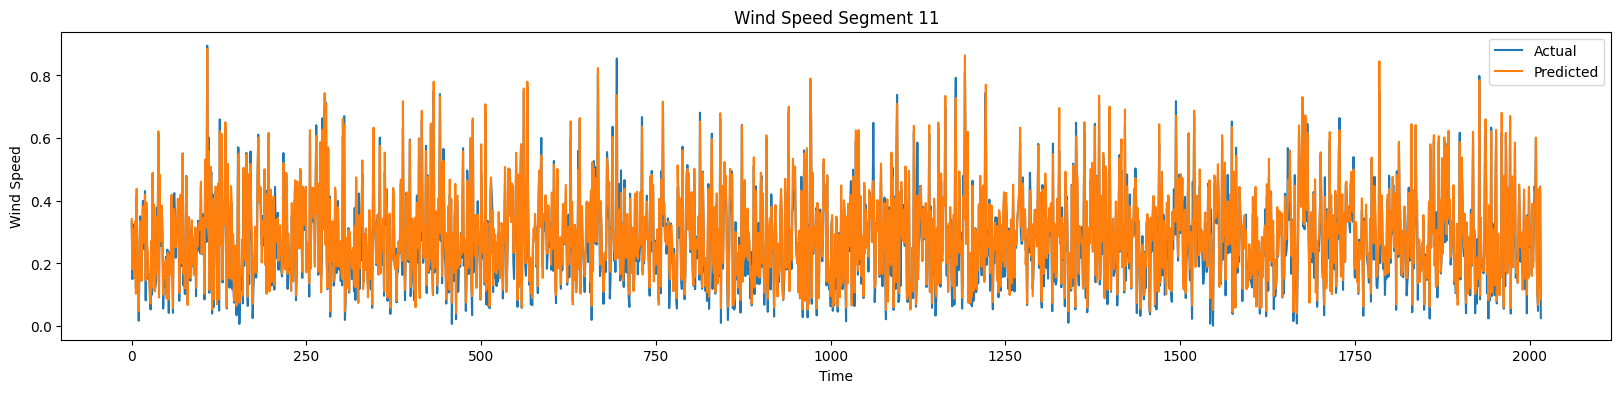

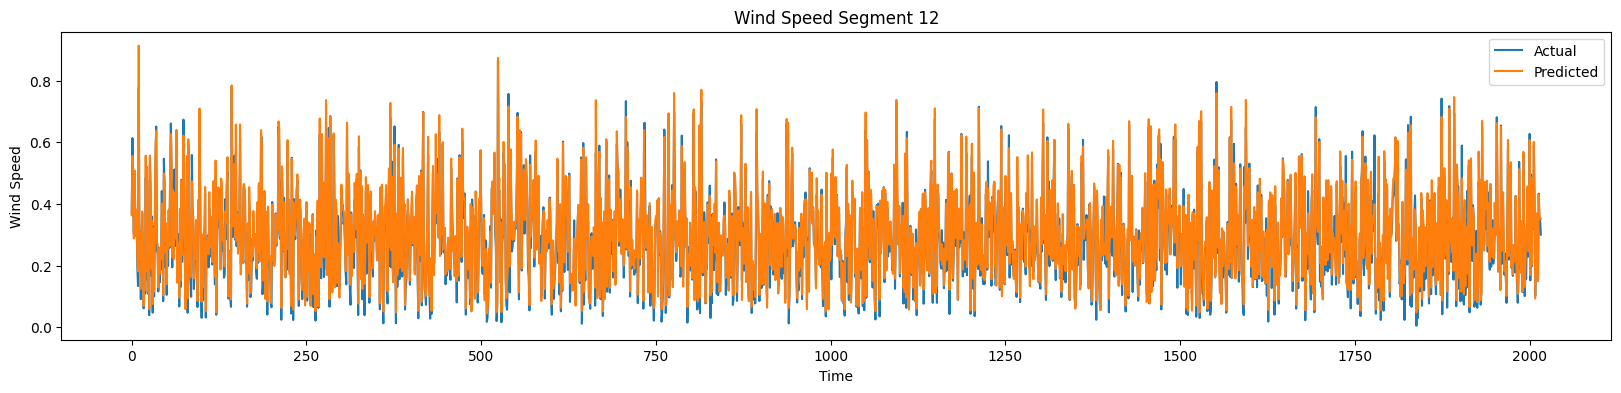

In [44]:
# Assuming y_test and y_pred are your actual and predicted values
num_plots = 12
total_points = len(y_test)
points_per_plot = total_points // num_plots

for i in range(num_plots):
    plt.figure(figsize=(20, 4))  # Adjust the size as needed
    start_idx = i * points_per_plot
    end_idx = start_idx + points_per_plot

    plt.plot(y_test[start_idx:end_idx], label='Actual')
    plt.plot(y_pred[start_idx:end_idx], label='Predicted')
    plt.title(f'Wind Speed Segment {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Wind Speed')
    plt.legend()
    plt.show()